# Notebook for Fruit Image classification
classification of fruit using fastai library (docs.fast.ai), which runs on top of pytorch

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

TODO provare a aggiungere altre metriche

In [34]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import CSVLogger
from fastai.widgets import *
from pathlib import Path
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
path_img = Path("/root/fruit-detection/dataset_classification")
batch_size = 64
np.random.seed(20) #random seed for reproduce results

create dataset object using a folder source folder formatted as `label1/* label2/* ..`. Do not use cross validation, split it 80% 20 % for training validation. Apply all fastai builtin transformations and normalize (still need to understand well what it does)

#### Dataset creation
Information available at the following link https://docs.fast.ai/vision.data.html#ImageDataBunch

In [4]:
data = ImageDataBunch.from_folder(path_img,ds_tfms=get_transforms(), size=224, bs=batch_size).normalize(imagenet_stats)

In [5]:
data.classes

['Albicocca',
 'Banana',
 'Carota',
 'Cetriolo',
 'Champignon',
 'Ciliegia',
 'Cipolla',
 'Kiwi',
 'Lime',
 'Mela',
 'Patata',
 'Peperoncino',
 'Pera',
 'Pesca',
 'Prugna rossa',
 'Zucchino',
 'pomodoro_ciliegino',
 'pomodoro_sanmarzano']

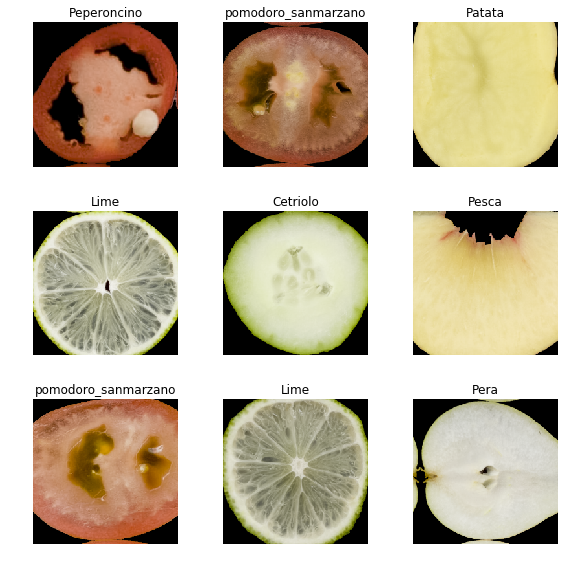

In [6]:
#show some images from dataset
data.show_batch(rows=3, figsize=(8,8))

#### CNN Model
Create a model using renet34 pretrained on imagenet

In [8]:
learn = create_cnn(data, models.resnet34, metrics=[error_rate], callback_fns=[CSVLogger])

In [9]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


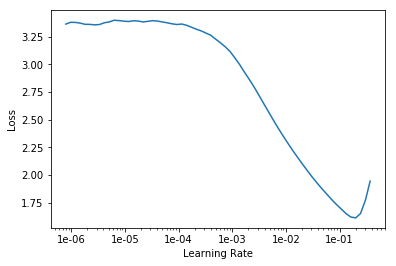

In [10]:
learn.recorder.plot()

Regarding under/overfitting problems, please refer to the following links:
1. https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error/187404#187404
2. https://link.springer.com/article/10.1007/s13244-018-0639-9

In [11]:
epochs = 3
lr = 1e-3
learn.fit_one_cycle(epochs, lr) #make 4 learning epoch

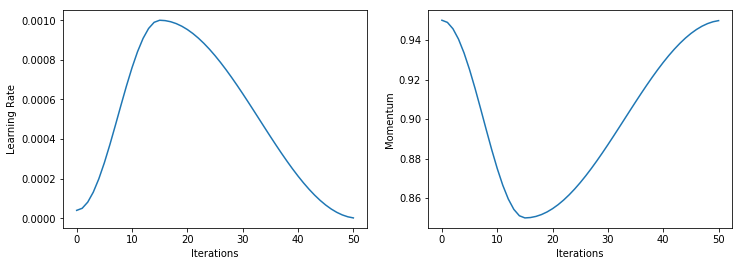

In [12]:
learn.recorder.plot_lr(show_moms=True)

Text(0, 0.5, 'Error rate')

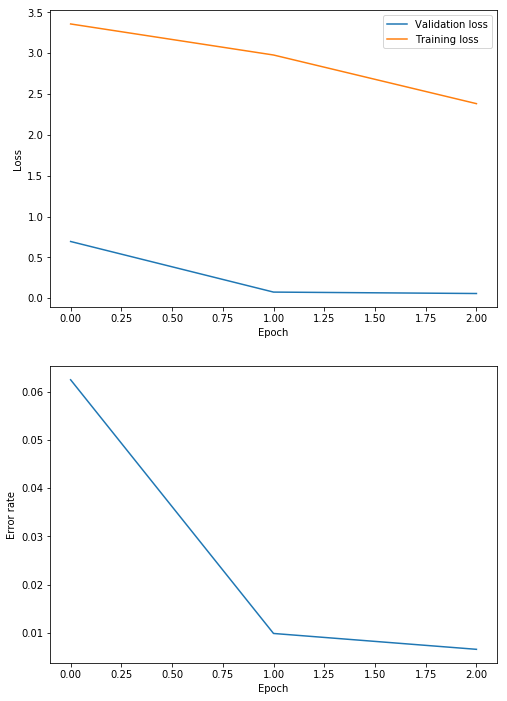

In [13]:
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(epochs)),learn.recorder.val_losses, label='Validation loss')
ax[0].plot(list(range(epochs)),[learn.recorder.losses[i] for i in range(epochs+2,epochs*(epochs+3),epochs+3)], label='Training loss')
#ax[0].plot(list(range(epochs)),[learn.recorder.losses[i] for i in range(0,len(learn.recorder.losses),epochs-3)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(epochs)),learn.recorder.metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Error rate')

In [14]:
learn.save('roberto_model-1', return_path=True)

PosixPath('/root/fruit-detection/dataset_classification/models/roberto_model-1.pth')

In [568]:
#learn.load('roberto_model-1')

In [42]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

In [43]:
ImageCleaner(ds, idxs, path_img)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

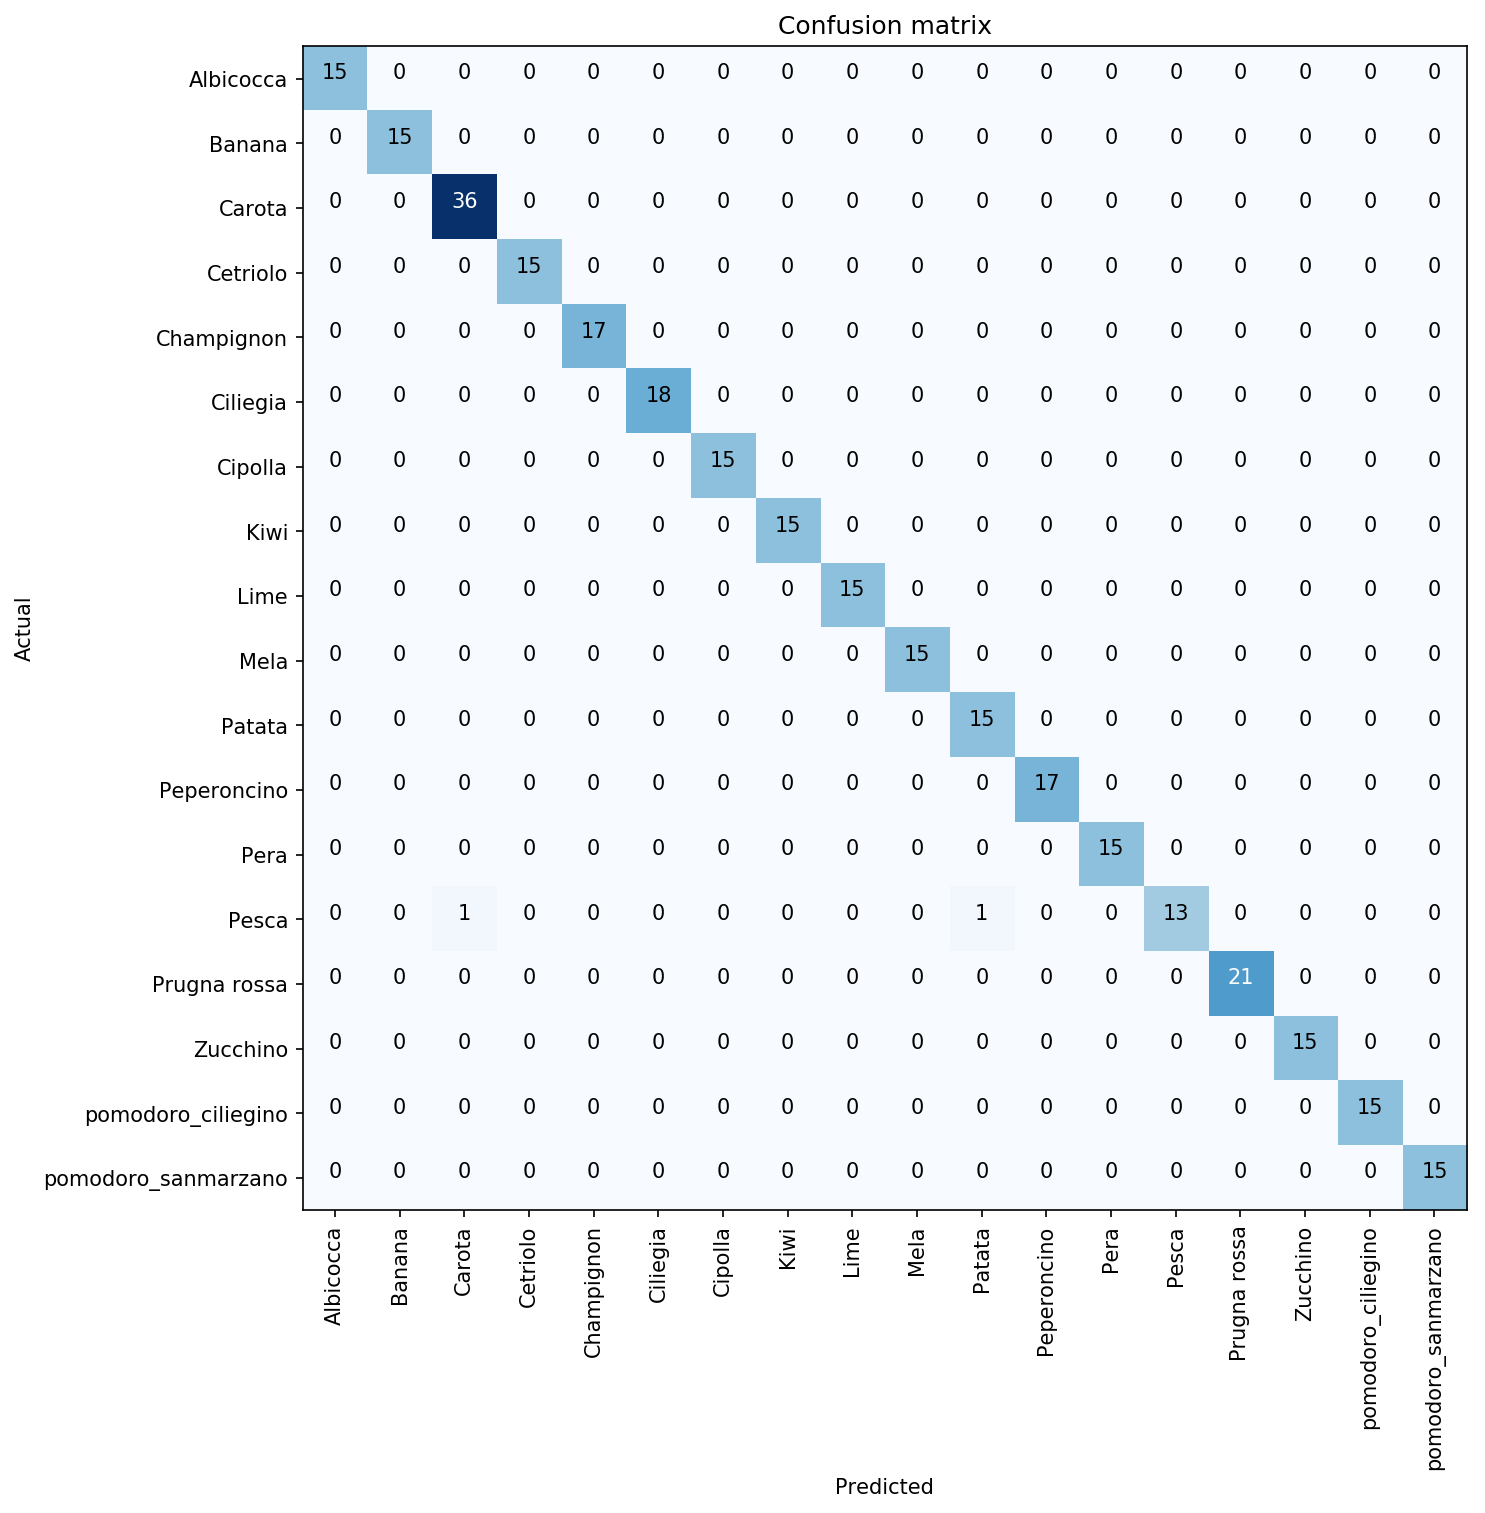

In [16]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=150)

In [17]:
interp.most_confused(min_val=1)

[('Pesca', 'Carota', 1), ('Pesca', 'Patata', 1)]

#### Commento di Roberto
Dai uno sguardo a questo paragrafo https://docs.fast.ai/vision.learner.html#ClassificationInterpretation
La probability è molto importante per capire la capacità predittiva di un modello.
Per ogni singola immagine è possibile capire con quale probabilità questa è stata associata al label corretto.
Più è alto tale valore, più ovviamente il modello funziona bene.
Se guardi la prima immagine in alto a sx, la prugna rossa ha una probability del 57% di essere prugna rossa (non è proprio così eccelente).
Estrarre le metriche da ogni immagine e mediarle per classe, ci può aiutare a descrivere la bontà del modello per ogni classe di prodotto ed a migliorarlo di conseguenza (facendo per esempio il transfer learning su altre CNN).
Insomma, non ci dobbiamo fermare all'errore totale di predizione (o, viceversa, alla sola accuratezza media del modello, che corrisponde a 1 - error_rate)

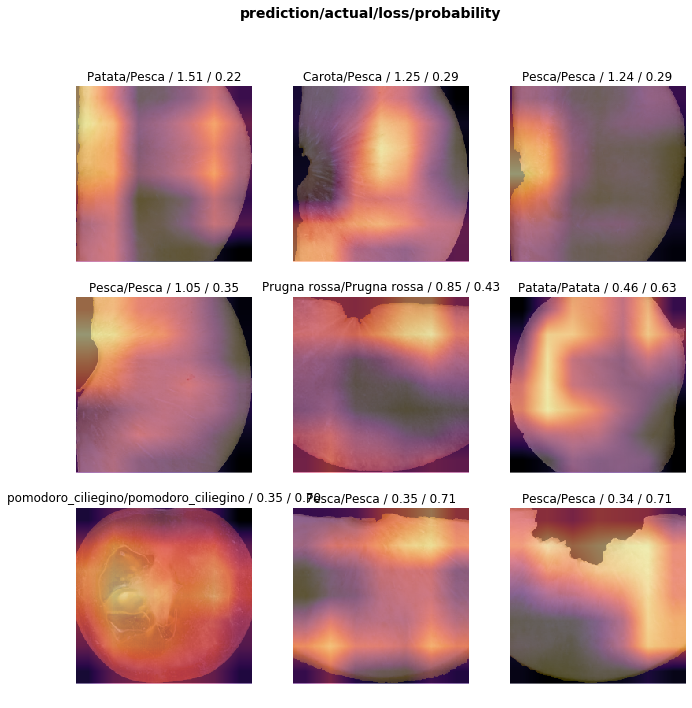

In [18]:
interp.plot_top_losses(9, figsize=(11,11))

In [19]:
test_path = Path("dataset_classification_final_test/")

In [20]:
defaults.device = torch.device('cpu')
tot = 0
wrong = 0
actual_idx = 0
results = {}

folders_list = sorted([folders for folders in test_path.iterdir()])
for folder in folders_list:
    results[folder.name] = {'path':[], 'actual_idx': [actual_idx], 'pred_idx': [], 'pred_class': [],'pred_class': [], 'probability': [], 'misclassified': []}
    files_list = [files for files in folder.iterdir() if files.suffix == '.png']
    for f in files_list:
        missClass = False
        img = open_image(f)
        pred_class,pred_idx,outputs = learn.predict(img)
        tot += 1
        if not (str(pred_class) == folder.name):
            wrong +=1
            print(f"pred class: {pred_class} vs actual {folder.name}")
            print(img)
            missClass = True
        results[folder.name]['path'].append(f)
        results[folder.name]['pred_idx'].append(int(pred_idx))
        results[folder.name]['pred_class'].append(str(pred_class))
        results[folder.name]['probability'].append(outputs)
        results[folder.name]['misclassified'].append(missClass)
    actual_idx += 1
        
print(f"error rate: {round(wrong/tot*100,2)}%")   

pred class: Prugna rossa vs actual Pesca
Image (3, 575, 362)
pred class: Prugna rossa vs actual Pesca
Image (3, 632, 380)
pred class: Patata vs actual Pesca
Image (3, 585, 406)
pred class: Patata vs actual Pesca
Image (3, 426, 552)
pred class: Patata vs actual Pesca
Image (3, 481, 358)
error rate: 0.81%


In [566]:
def pred_analysis(fclass, fresults, verbose, picture):
    counter = 0
    no_errors = True
    try:
        for i in fresults[fclass]['misclassified']:
            if i == True:
                no_errors = False
                idx = fresults[fclass]['pred_idx'][counter]
                prob = round(float(fresults[fclass]['probability'][counter][idx])*100,2)
                print(f"Actual {fclass} recognised as {fresults[fclass]['pred_class'][counter]} (image n.{str(counter)} - pred_idx: {idx}, P: {str(prob)}%)")
                if picture:
                    display(Image(str(fresults[fclass]['path'][counter]), width=100))
            counter += 1
        if no_errors and verbose:
            print(f"Actual {fclass} - no classification errors")
                      
    except KeyError:
        print("Not available class")
                      
def pred_error(fclass, fresults, verbose = False, picture = False):
    if fclass == 'all':
        for i in range(0, len(fresults)):
            pred_analysis(list(results.keys())[i], fresults, verbose, picture)         
    else:
        pred_analysis(fclass, fresults, verbose, picture)

                      
# the function extracts the average probability values for an actual class
def pred_plot(actual_class, fresults, plot = True):
    try:
        # acquire the list of classes
        classes = list(fresults.keys())
                      
        # acquire the number of samples
        samples = len(results[actual_class]['probability'])
        
        ave_probs = []
                      
        for c in classes:
             # exctract the pred_idx from each class
            idx = fresults[c]['actual_idx'][0]
            temp_probs = []
             
            # extract the probability associated to each class for every sample          
            for s in range(samples):
                temp_probs.append(fresults[actual_class]['probability'][s][idx])
           
            # compute the average probability on class at time
            ave_probs.append(np.mean(temp_probs)) 

        if plot:
            # barplot colors
            bar_colors = ['gray']*(len(classes)+1)
            bar_colors[fresults[actual_class]['actual_idx'][0]] = 'blue'
            miss_array = np.array(results[actual_class]['misclassified'])
            index_array = np.array(results[actual_class]['pred_idx'])
            miss_classes = index_array[miss_array]
            miss_classes = np.unique(miss_classes)
            for i in miss_classes:
                bar_colors[i] = 'red'

            # barplot show
            plt.ylim(0, 1)
            plt.ylabel('Average probability')
            plt.xticks(range(len(ave_probs)), classes, rotation = 'vertical')
            plt.bar(range(len(ave_probs)), ave_probs, color = bar_colors)

            blue_patch = mpatches.Patch(color='blue', label='Correctly classified')
            red_patch = mpatches.Patch(color='red', label='Misclassified')
            gray_patch = mpatches.Patch(color='gray', label='Correctly discarded')
            plt.legend(handles=[blue_patch, gray_patch, red_patch])
        
        # averaged probability
        return ave_probs
    
    except KeyError:
        print("Not available class")

def pred_hist(actual_class, fresults, xlim = [-.01,1.01], bins = 20, delta = 0.03, density = True, facecolor = 'blue'):
    probs = []
    miss = []
    try:
        idx = fresults[actual_class]['actual_idx'][0]
        samples = len(results[actual_class]['probability'])

        for s in range(samples):
            probs.append(float(fresults[actual_class]['probability'][s][idx]))
            miss.append(float(fresults[actual_class]['misclassified'][s]))
        
        plt.xlim(xlim[0], xlim[1])
        plt.title(actual_class)
        plt.xlabel('Probability')

        if density:
            plt.ylabel('Density')
        else:
            plt.ylabel('Frequency')

        n, bins, _ = plt.hist(probs, bins = bins, density = density, facecolor=facecolor, alpha = 0.75)

        nbins = []
        for i in range(len(bins[:-1])):
            nbins.append((bins[i]+bins[i+1])/2)
        nbins = np.asarray(nbins) 
                      
        D = max(n)*delta

        for m in range(samples):
            if miss[m]:
                i = (np.abs(nbins - probs[m])).argmin()
                dot = plt.plot(nbins[i], n[i]+D, ".r")
        
        try:
            plt.legend(dot, ["misclassified samples"])
        except UnboundLocalError:
            pass
                      
    except KeyError:
        print("Not available class")
    return n, bins
                      

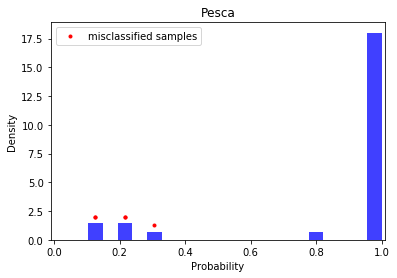

In [570]:
n, bins = pred_hist('Pesca', results)

Actual Pesca recognised as Prugna rossa (image n.10 - pred_idx: 14, P: 43.13%)


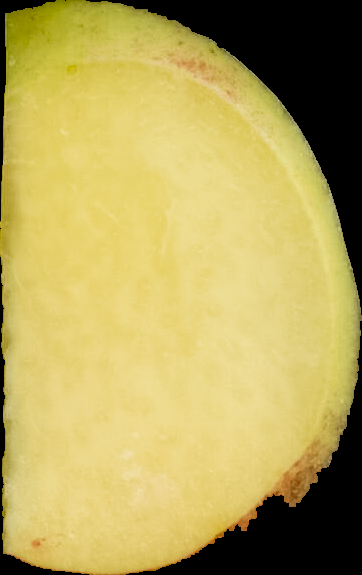

Actual Pesca recognised as Prugna rossa (image n.11 - pred_idx: 14, P: 74.19%)


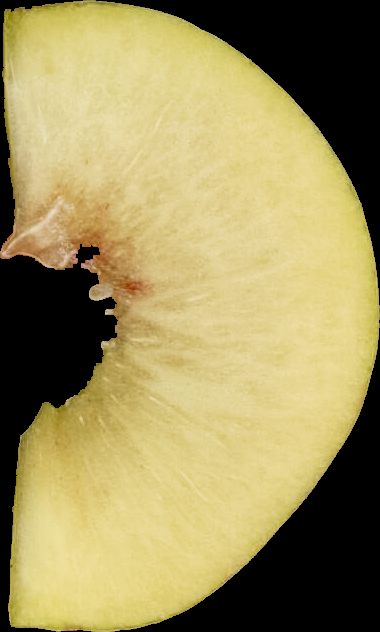

Actual Pesca recognised as Patata (image n.13 - pred_idx: 10, P: 38.27%)


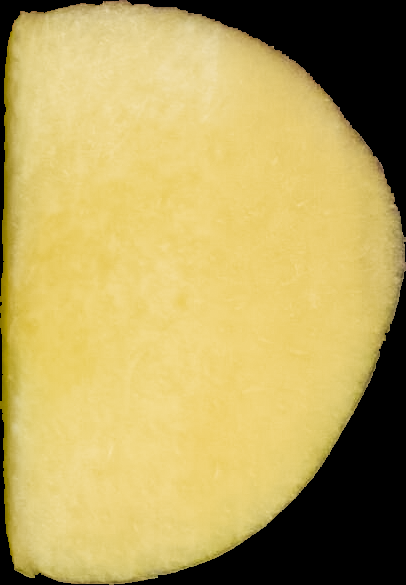

Actual Pesca recognised as Patata (image n.25 - pred_idx: 10, P: 21.32%)


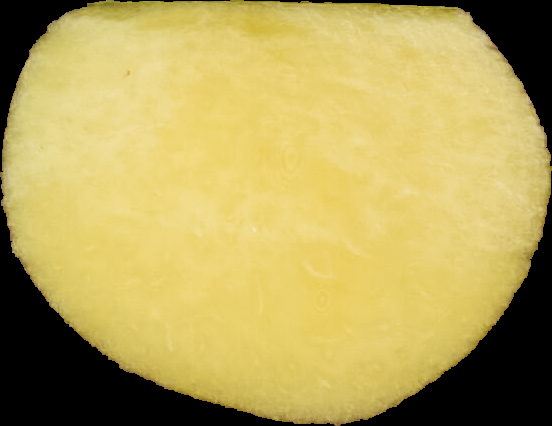

Actual Pesca recognised as Patata (image n.26 - pred_idx: 10, P: 25.0%)


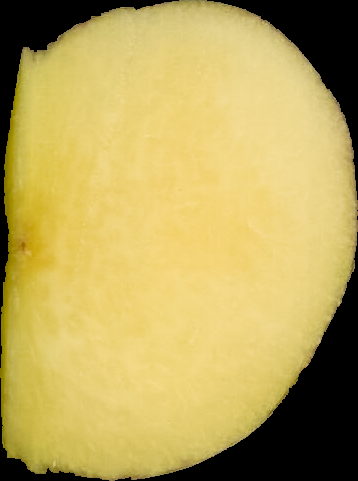

In [572]:
pred_error('all', results, False, True)

The plot here below refers to the tutorial available at the following link:
https://www.tensorflow.org/tutorials/keras/basic_classification

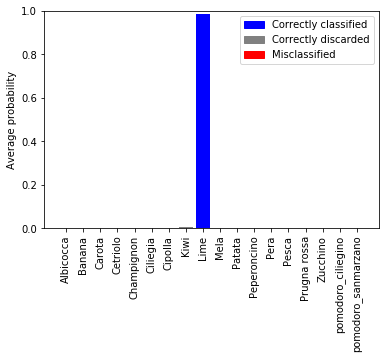

In [575]:
probs = pred_plot('Lime', results)

In [145]:
#probs

In [143]:
#dir(learn)

In [144]:
#learn.data

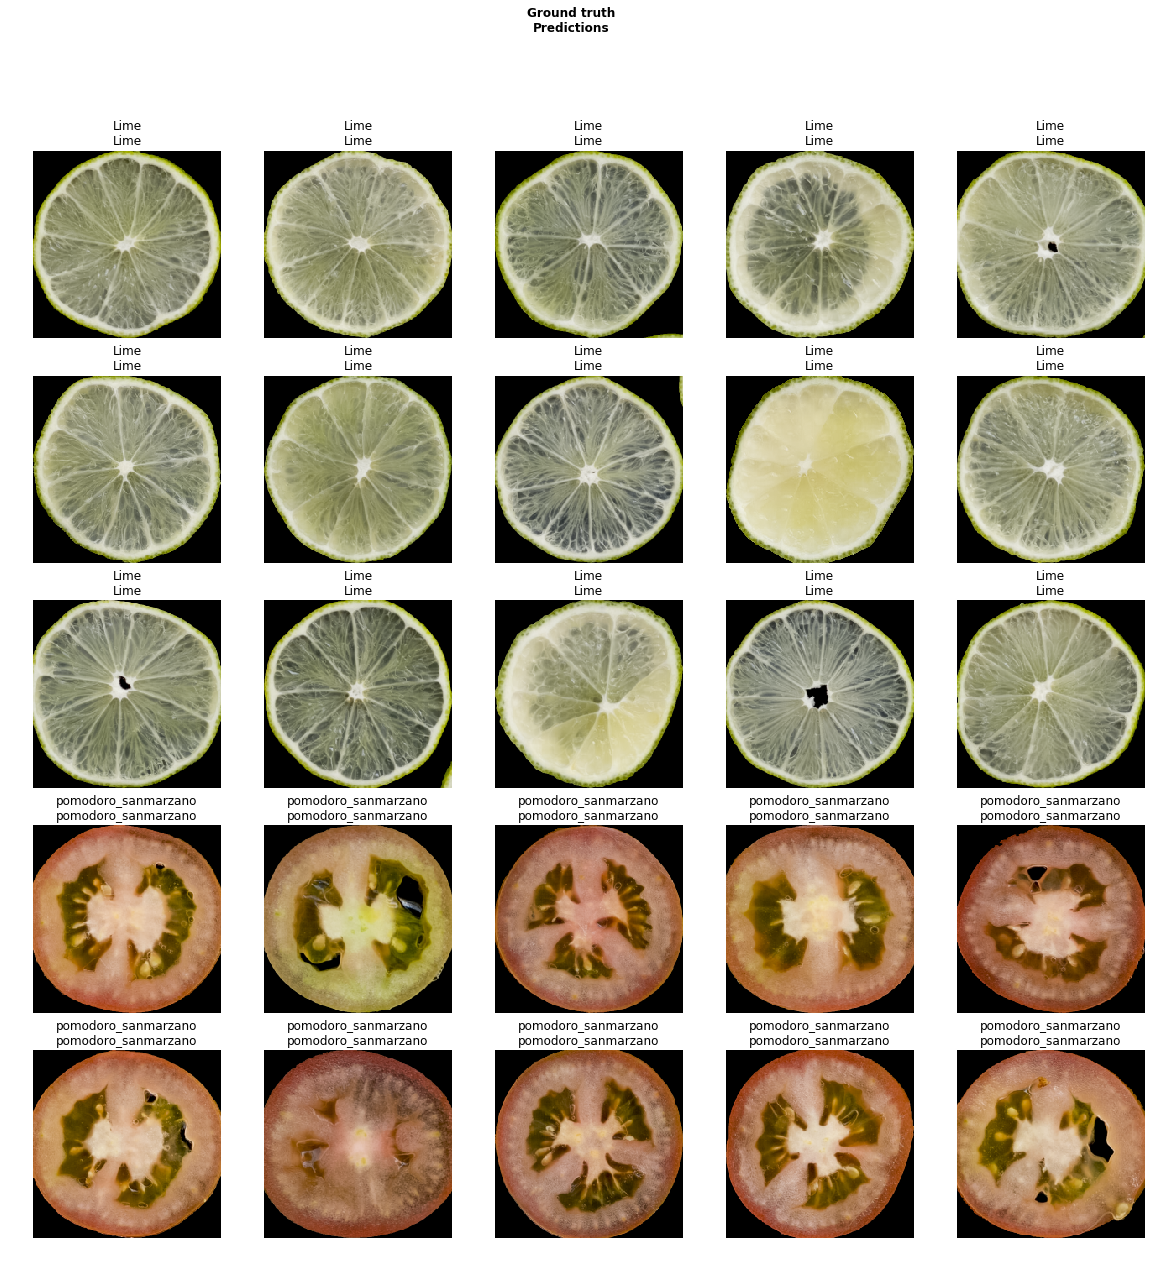

In [32]:
learn.show_results()

In [28]:
learn.validate()

[0.05689089, tensor(0.0066)]